# 数据的处理

In [408]:
#导入需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [409]:
#数据读取
train_set_1 = pd.read_csv('train_hf_data.csv',header=0,index_col=0)
train_set_1_label = pd.read_csv('train_hf_label.csv',header=0,index_col=0)
test_set_1 = pd.read_csv('test_hf_data.csv',header=0,index_col=0)
test_set_1_label = pd.read_csv('test_hf_label.csv',header=0,index_col=0)

In [410]:
#设计函数清理不在给定范围内的样本
def data_clean(data):
    D = data
    D = D.drop(D[(D.age < 40) | (D.age > 95)].index)
    D = D.drop(D[(D.creatinine_phosphokinase < 23) | (D.creatinine_phosphokinase > 7861)].index)
    D = D.drop(D[(D.ejection_fraction < 14) | (D.ejection_fraction > 80)].index)
    D = D.drop(D[(D.platelets < 25010) | (D.platelets > 850000)].index)
    D = D.drop(D[(D.serum_creatinine < 0.5) | (D.serum_creatinine > 9.4)].index)
    D = D.drop(D[(D.serum_sodium < 114) | (D.serum_sodium > 148)].index)
    D = D.drop(D[(D.time < 4) | (D.time > 285)].index)
    return D.reset_index(drop=True)

In [411]:
#设计函数将数据按附件给的正常范围进行归一化处理
#这个函数是用的老师给的数据范围进行归一化的
def normalization(data):
    D = np.array(data)
    min_range = np.array([[40,55],[0,1],[23,7838],[0,1],[14,66],[0,1],[25010,825000],[0.5,8.9],[114,34],[0,1],[0,1],[4,281]])
    def maxminNormalize(X,X_min,X_range):
        return (X-X_min) / X_range
    for i in range(len(D[0]-1)):
        for j in range(len(D[:,0]-1)):
            D[j][i] = maxminNormalize(D[j][i],min_range[i][0],min_range[i][1])
    return D     

In [412]:
#设计函数将特征矩阵转换为老师模式识别课本中需要的计算形式
def transform(data,label):
    data = np.append(data,np.ones(len(data[:,0])).reshape(len(data[:,0]),1),axis=1)
    label = label
    for i in range(len(data[:,0])):
        if label[i] == 0:
            data[i] = -data[i]
    return data

In [413]:
#对数据进行清洗
#对训练集清洗
train_set_1_merge = pd.concat([train_set_1,train_set_1_label],axis=1)#为了数据清洗方便，先将标签合并上去
train_set_1_merge = data_clean(train_set_1_merge)#清除不在范围的样本及标签
train_set_1 = train_set_1_merge.drop('label',axis=1)#将特征矩阵分离出来
train_set_1_label = train_set_1_merge['label']#将标签分离出来
#对测试集清洗
test_set_1_merge = pd.concat([test_set_1,test_set_1_label],axis=1)#为了数据清洗方便，先将标签合并上去
test_set_1_merge = data_clean(test_set_1_merge)#清除不在范围的样本及标签
test_set_1 = test_set_1_merge.drop('label',axis=1)#将特征矩阵分离出来
test_set_1_label = test_set_1_merge['label']#将标签分离出来

In [414]:
#将数据转换成多维数组并进行标准化
#将数据全部转换为矩阵
train_set_1 = np.array(train_set_1)
test_set_1 = np.array(test_set_1)
train_set_1_label = np.array(train_set_1_label)
test_set_1_label = np.array(test_set_1_label)
#对训练集及测试集的特征矩阵进行归一化
train_set_1_normal = normalization(train_set_1)
test_set_1_normal = normalization(test_set_1)

In [415]:
#看看转换是否成功
print(train_set_1.shape)
print(test_set_1.shape)
print(train_set_1_label.shape)
print(test_set_1_label.shape)

(239, 12)
(59, 12)
(239,)
(59,)


In [416]:
#将数据转换为运算的形式
train_set_1_normal = transform(train_set_1_normal,train_set_1_label)
test_set_1_normal = transform(test_set_1_normal,test_set_1_label)

In [417]:
#感知器模型
class Model:
    def __init__(self):
        self.w = np.ones(13, dtype=np.float32)
        self.l_rate = 0.1#定义w矩阵与学习率

    def sign(self, x, w):
        y = np.dot(x, w)
        return y#定义计算形式

    def fit(self, X_train):#训练函数
        is_wrong = False#定义停止迭代的标签
        count = 0#定义迭代计数器
        loss_sum = list()#定义一个空表，之后存每轮的损失函数
        while not is_wrong:
            count += 1#迭代次数加一
            wrong_count = 0#定义每次迭代中的误分类点数
            loss = 0#每次迭代中误分类点的损失
            for d in range(len(X_train)):
                X = X_train[d]
                if self.sign(X, self.w) <= 0:#如果误分类
                    loss = loss + abs((self.sign(X, self.w)))#计算损失函数
                    #self.w = self.w + abs(((self.sign(X, self.w)) / np.dot(X,X))) * X#梯度下降，用可变步长
                    self.w = self.w + self.l_rate* X#梯度下降，用固定步长
                    wrong_count += 1#错误点数加一
            loss_sum= np.append(loss_sum,loss)#损失函数表尾加一
            if ((wrong_count == 0) | (count > 1000)):#如果全部正确分类，或迭代次数超过1000，改变标签，停止迭代
                is_wrong = True
                print(count)#输出迭代次数，用以判断是收敛了，还是超过了最大迭代次数
                plt.plot(loss_sum)#出图损失函数
        return 'Done!'
    def test(self,Y):#定义测试函数
        return self.sign(Y,self.w)
perceptron = Model()

1001


<IPython.core.display.Javascript object>


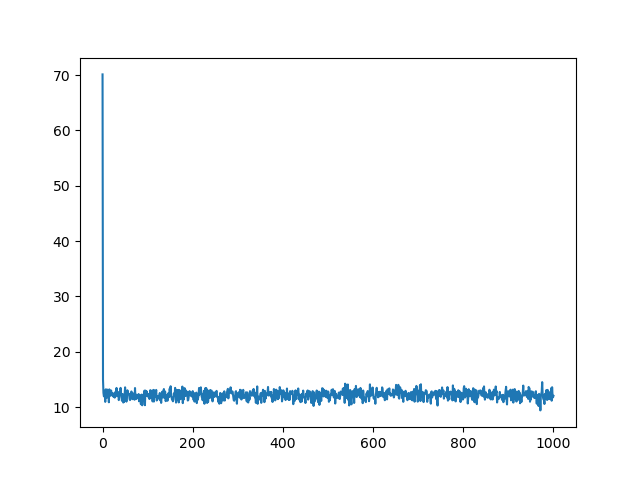

'Done!'

In [418]:
perceptron.fit(train_set_1_normal)

In [419]:
#测试给定测试集的准确率

In [420]:
count_1 = 0
for i in (range(len(test_set_1_normal))):
    if perceptron.test(test_set_1_normal[i]) <= 0:
        count_1 += 1
print("不收敛点数：",count_1)
print("Error rate：",count_1/len(test_set_1_normal))

不收敛点数： 17
Error rate： 0.288135593220339
